<a href="https://colab.research.google.com/github/HwiTran/Natural-Language-Processing-Course/blob/main/seq2seq_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 14.4 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


# Prepare dataset

In [2]:
import numpy as np
import random, spacy, datasets

import torch
from torch import nn
import torchtext

### Dataset

Next, we'll load our dataset using the `datasets` library. When using the `load_dataset` function we pass the name of the dataset, `bentrevett/multi30k`.

The dataset we'll be using is a subset of the [Multi30k dataset](https://github.com/multi30k/dataset), which is hosted [here](https://huggingface.co/datasets/bentrevett/multi30k) on the HuggingFace dataset hub. This subset has ~30,000 parallel English and German sentences obtained using the task 1 raw data from [here](https://github.com/multi30k/dataset/tree/master/data/task1/raw). We use the "2016" versions of the test sets.


In [3]:
dataset = datasets.load_dataset("bentrevett/multi30k")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/29000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1014 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

We can see the `dataset` object (a `DatasetDict`) contains the train, validation and test splits, the amount of examples in each split, and the features in each split ("en" and "de").


In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['en', 'de'],
        num_rows: 29000
    })
    validation: Dataset({
        features: ['en', 'de'],
        num_rows: 1014
    })
    test: Dataset({
        features: ['en', 'de'],
        num_rows: 1000
    })
})

For convenience, we create a variable for each split. Each being a `Dataset` object.


In [5]:
train_data, valid_data, test_data = (
    dataset["train"],
    dataset["validation"],
    dataset["test"],
)

We can index into each `Dataset` to view an individual example. Each example has two features: "en" and "de", which are the parallel English and German sentences.


In [6]:
train_data[0]

{'en': 'Two young, White males are outside near many bushes.',
 'de': 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.'}

### Tokenizers

Next, we'll load the spaCy models that contain the tokenizers.

A tokenizer is used to turn a string into a list of tokens that make up that string, e.g. "good morning!" becomes ["good", "morning", "!"]. We'll start talking about the sentences being a sequence of tokens from now, instead of saying they're a sequence of words. What's the difference? Well, "good" and "morning" are both words and tokens, but "!" is not a word. We could say "!" is punctuation, but the term token is more general and covers: words, punctuation, numbers and any special symbols.

spaCy has model for each language ("de_core_news_sm" for German and "en_core_web_sm" for English) which need to be loaded so we can access the tokenizer of each model.


We load the models as such:


In [7]:
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 30.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 35.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [8]:
en_nlp = spacy.load("en_core_web_sm")
de_nlp = spacy.load("de_core_news_sm")

We can call the tokenizer for each spaCy model using the `.tokenizer` method, which accepts a string and returns a sequence of `Token` objects. We can get the string from the token object using the `text` attribute.


In [9]:
string = "What a lovely day it is today!"

[token.text for token in en_nlp.tokenizer(string)]

['What', 'a', 'lovely', 'day', 'it', 'is', 'today', '!']

Next, we'll write a function used to apply the tokenizer to all of the examples in each data split, as well as apply some other processing.

This function takes in an example from the `Dataset` object, applies the tokenizers English and German spaCy models, trims the list of tokens to a maximum length, optionally converts each token to lowercase, and then appends the start of sequence and end of sequence tokens to the beginning and end of the list of tokens.

This function will be used with the `map` method from a `Dataset`, which needs to return a dictionary containing the names of the features in each example where the outputs are stored. As the output feature names "en_tokens" and "de_tokens" are not already contained in the example (where we only have "en" and "de" features), this will create two new features in each example.


In [10]:
def tokenize_example(example, en_nlp, de_nlp, max_length, lower, sos_token, eos_token):
    en_tokens = [token.text for token in en_nlp.tokenizer(example["en"])][:max_length]
    de_tokens = [token.text for token in de_nlp.tokenizer(example["de"])][:max_length]
    if lower:
        en_tokens = [token.lower() for token in en_tokens]
        de_tokens = [token.lower() for token in de_tokens]
    en_tokens = [sos_token] + en_tokens + [eos_token]
    de_tokens = [sos_token] + de_tokens + [eos_token]
    return {"en_tokens": en_tokens, "de_tokens": de_tokens}

We apply the `tokenize_example` function using the `map` method as below.

The `example` argument is implied, however all additional arguments to the `tokenize_example` function need to be stored in a dictionary and passed to the `fn_kwargs` argument of `map`.

Here, we're trimming all sequences to a maximum length of 1000 tokens, converting each token to lower case, and using `<sos>` and `<eos>` as the start and end of sequence tokens, respectively.


In [11]:
max_length = 1_000
lower = True
sos_token = "<sos>"
eos_token = "<eos>"

fn_kwargs = {
    "en_nlp": en_nlp,
    "de_nlp": de_nlp,
    "max_length": max_length,
    "lower": lower,
    "sos_token": sos_token,
    "eos_token": eos_token,
}

train_data = train_data.map(tokenize_example, fn_kwargs=fn_kwargs)
valid_data = valid_data.map(tokenize_example, fn_kwargs=fn_kwargs)
test_data = test_data.map(tokenize_example, fn_kwargs=fn_kwargs)

Map:   0%|          | 0/29000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1014 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

We can now look at an example, confirming the two new features have been added; both of which are lowercased list of strings with the start/end of sequence tokens appended.


In [12]:
train_data[0]

{'en': 'Two young, White males are outside near many bushes.',
 'de': 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.',
 'en_tokens': ['<sos>',
  'two',
  'young',
  ',',
  'white',
  'males',
  'are',
  'outside',
  'near',
  'many',
  'bushes',
  '.',
  '<eos>'],
 'de_tokens': ['<sos>',
  'zwei',
  'junge',
  'weiße',
  'männer',
  'sind',
  'im',
  'freien',
  'in',
  'der',
  'nähe',
  'vieler',
  'büsche',
  '.',
  '<eos>']}

### Vocabularies

Next, we'll build the _vocabulary_ for the source and target languages. The vocabulary is used to associate each unique token in our dataset with an index (an integer), e.g. "hello" = 1, "world" = 2, "bye" = 3, "hates" = 4, etc. When feeding text data to our model, we convert the string into tokens and then the tokens into numbers using the vocabulary as a look up table, e.g. "hello world" becomes `["hello", "world"]` which becomes `[1, 2]` using the example indices given. We do this as neural networks cannot operate on strings, only numerical values.

We create the vocabulary (one for each language) from our datasets using the `build_vocab_from_iterator` function, provided by `torchtext`, which accepts an iterator where each item is a list of tokens. It then counts up the number of unique tokens and assigns each a numerical value.

In theory, our vocabulary can be large enough to have an index for every unique token in our dataset. However, what happens if a token exists in our validation and test set, but not in our training set? In that case, we replace the token with an "unknown token", denoted by `<unk>`, which is given its own index (usually index zero). All unknown tokens are replaced by `<unk>`, even if the tokens are different, i.e. if the tokens "gilgamesh" and "enkidu" were both not within our vocabulary, then the string "gilgamesh hates enkidu" gets tokenized to `["gilgamesh", "hates", "enkidu"]` and then becomes `[0, 24, 0]` (where "hates" has the index 24).

Ideally, we want our model to be able to handle unknown tokens by learning to use the context around them to make translations. The only way it can learn that is if we also have unknown tokens in the training set. Hence, when creating our vocabularies with `build_vocab_from_iterator`, we use the `min_freq` argument to not create an index for tokens which appear less than `min_freq` times in our training set. In other words, when using the vocabulary, any token which does not appear at least twice in our training set will get replaced by the unknown token index when converting tokens to indices.

It is important to note that a vocabulary should only be built from the training set and never the validation or test set. This prevents "information leakage" into our model, giving us artifically inflated validation/test scores.

We also use the `specials` argument of `build_vocab_from_iterator` to pass _special tokens_. These are tokens which we want to add to the vocabulary but do not necessarily appear in our tokenized examples. These special tokens will appear first in the vocabulary. We've already discussed the `unk_token`, `sos_token`, and `eos_token`. The final special token is the `pad_token`, denoted by `<pad>`.

When inputting sentences into our model, it is more efficient to pass multiple sentences at once (known as a batch), instead of one at a time. The requirement for sentences to be batched together is that they all have to be the same length (in terms of the number of tokens). The majority of our sentences are not the same length, but we can solve this by "padding" (adding `<pad>` tokens) the tokenized version of each sentence in a batch until they all have equal tokens to the longest sentence in the batch. For example, if we had two sentences: "I love pizza" and "I hate music videos". They would be tokenized to something like: `["i", "love", "pizza"]` and `["i", "hate", "music", "videos"]`. The first sequence of tokens would then be padded to `["i", "love", "pizza", "<pad>"]`. Both sequences could then be converted to indexes using the vocabulary.

That was a lot of information, but luckily `torchtext` handles all the fuss of building the vocabulary. We'll handle the padding and batching later.


In [13]:
min_freq = 2
unk_token = "<unk>"
pad_token = "<pad>"

special_tokens = [
    unk_token,
    pad_token,
    sos_token,
    eos_token,
]

en_vocab = torchtext.vocab.build_vocab_from_iterator(
    train_data["en_tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

de_vocab = torchtext.vocab.build_vocab_from_iterator(
    train_data["de_tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

Now we have our vocabularies, we can check what's actually in them.

We can get the first ten tokens in our vocabulary (indices 0 to 9) using the `get_itos` method, where itos = "**i**nt **to** **s**tring", which returns a list of tokens.


In [14]:
en_vocab.get_itos()[:10]

['<unk>', '<pad>', '<sos>', '<eos>', 'a', '.', 'in', 'the', 'on', 'man']

In [15]:
en_vocab.get_itos()[9]

'man'

We can do the same for the German vocabulary. Notice how the special tokens are the same and in the same order (indices 0 to 3), however the rest are different. This is because the vocabularies were effectively created from different data (one English and one German) even though they were from the same examples. The indices given to tokens that are not special tokens are ordered from most frequent to least frequent (though still appearing at least `min_freq` times).


In [16]:
de_vocab.get_itos()[:10]

['<unk>', '<pad>', '<sos>', '<eos>', '.', 'ein', 'einem', 'in', 'eine', ',']

We can get the index from a given token using the `get_stoi` (stoi = " **s**tring **to** **i**nt) method.


In [17]:
en_vocab.get_stoi()["the"]

7

As a shorthand, we can just use the vocabulary as a dictionary and pass the token to get the index. Note that this doesn't work the other way around, i.e. `en_vocab[7]` does not work.


In [18]:
en_vocab["the"]

7

The `len` of each vocabulary gives us the number of unique tokens in each one. We can see that our training data had around 2000 more German tokens (that appeared at least twice) than the English data.


In [19]:
len(en_vocab), len(de_vocab)

(5893, 7853)

We can also use the `in` keyword to get a boolean indicating if a token is in the vocabulary.


In [20]:
"the" in en_vocab

True

Remember how we converted all of our tokens to lowercase? This means that no tokens containing any uppercase characters appear in our vocabulary.


In [21]:
"The" in en_vocab

False

What happens if you try and get the index of a token that isn't in the vocabulary? You get index zero for the `<unk>` (unknown) token, right?

Well, no. One quirk of the `torchtext` vocabulary class is that you have to manually set what value you want your vocabulary to return when you try and get the index of an out-of-vocabulary token. If you have not set this value, then you will receive an error! This is so you can set your vocabulary to return any value when trying to get the index of a token not in the vocabulary, even something like `-100`.


We already know the index of our `<unk>` token is zero as it's the first element in our `special_tokens` list, and we've also manually inspected it using `get_itos`.

However, here we'll programmatically get it and also check that both our vocabularies have the same index for the unknown and padding tokens as this simplifies some code later on.

We also get the index of our `<pad>` token, as we'll use it later


In [22]:
unk_index = en_vocab[unk_token]
pad_index = en_vocab[pad_token]

Using the `set_default_index` method we can set what value is returned when we try and get the index of a token outside of our vocabulary. In this case, the index of the unknown token, `<unk>`.


In [23]:
en_vocab.set_default_index(unk_index)
de_vocab.set_default_index(unk_index)

Now, we can happily get indexes of out of vocabulary tokens until our heart is content!


In [24]:
en_vocab["The"]

0

And we can get the token corresponding to that index to prove it's the `<unk>` token.


In [25]:
en_vocab.get_itos()[0]

'<unk>'

Another useful feature of the vocabulary is the `lookup_indices` method. This takes in a list of tokens and returns a list of indices. In the below example we can see the token "crime" does not exist in our vocabulary so is coverted to the index of the `<unk>` token, zero, which we passed to the `set_default_index` method.


In [26]:
tokens = ["i", "love", "watching", "crime", "shows"]

In [27]:
en_vocab.lookup_indices(tokens)

[956, 2169, 173, 0, 821]

Conversely, we can use the `lookup_tokens` method to convert a list of indices back into tokens using the vocabulary. Notice how the original "crime" token is now an `<unk>` token. There is no way to tell what the original sequence of tokens was.


In [28]:
en_vocab.lookup_tokens(en_vocab.lookup_indices(tokens))

['i', 'love', 'watching', '<unk>', 'shows']

Hopefully we've now got the gist of how the `torchtext.Vocab` class works. Time to put it into action!

Just like our `tokenize_example`, we create a `numericalize_example` function which we'll use with the `map` method of our dataset. This will "numericalize" (a fancy way of saying convert tokens to indices) our tokens in each example using the vocabularies and return the result into new "en_ids" and "de_ids" features.


In [29]:
def numericalize_example(example, en_vocab, de_vocab):
    en_ids = en_vocab.lookup_indices(example["en_tokens"])
    de_ids = de_vocab.lookup_indices(example["de_tokens"])
    return {"en_ids": en_ids, "de_ids": de_ids}

We apply the `numericalize_example` function, passing our vocabularies in the `fn_kwargs` dictionary to the `fn_kwargs` argument.


In [30]:
fn_kwargs = {"en_vocab": en_vocab, "de_vocab": de_vocab}

train_data = train_data.map(numericalize_example, fn_kwargs=fn_kwargs)
valid_data = valid_data.map(numericalize_example, fn_kwargs=fn_kwargs)
test_data = test_data.map(numericalize_example, fn_kwargs=fn_kwargs)

Map:   0%|          | 0/29000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1014 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Checking an example, we can see that it has the two new features: "en_ids" and "de_ids", both a list of integers representing their indices in the respective vocabulary.


In [31]:
train_data[0]

{'en': 'Two young, White males are outside near many bushes.',
 'de': 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.',
 'en_tokens': ['<sos>',
  'two',
  'young',
  ',',
  'white',
  'males',
  'are',
  'outside',
  'near',
  'many',
  'bushes',
  '.',
  '<eos>'],
 'de_tokens': ['<sos>',
  'zwei',
  'junge',
  'weiße',
  'männer',
  'sind',
  'im',
  'freien',
  'in',
  'der',
  'nähe',
  'vieler',
  'büsche',
  '.',
  '<eos>'],
 'en_ids': [2, 16, 24, 15, 25, 778, 17, 57, 80, 202, 1312, 5, 3],
 'de_ids': [2, 18, 26, 253, 30, 84, 20, 88, 7, 15, 110, 7647, 3171, 4, 3]}

We can confirm the indices are correct by using the `lookup_tokens` method with the corresponding vocabulary on the list of indices.


In [32]:
en_vocab.lookup_tokens(train_data[0]["en_ids"])

['<sos>',
 'two',
 'young',
 ',',
 'white',
 'males',
 'are',
 'outside',
 'near',
 'many',
 'bushes',
 '.',
 '<eos>']

One other thing that the `datasets` library handles for us with the `Dataset` class is converting features to the correct type. Our indices in each example are currently basic Python integers. However, they need to be converted to PyTorch tensors in order to use them with PyTorch. We could convert them just before we pass them into the model, however it is more convenient to do it now.

The `with_format` method converts features indicated by the `columns` argument to a given `type`. Here, we specify the type as "torch" (for PyTorch) and the columns to be "en_ids" and "de_ids" (the features which we want to convert to PyTorch tensors). By default, `with_format` will remove any features not in the list of features passed to `columns`. We want to keep those features, which we can do with `output_all_columns=True`.


In [33]:
data_type = "torch"
format_columns = ["en_ids", "de_ids"]

train_data = train_data.with_format(
    type=data_type, columns=format_columns, output_all_columns=True
)

valid_data = valid_data.with_format(
    type=data_type,
    columns=format_columns,
    output_all_columns=True,
)

test_data = test_data.with_format(
    type=data_type,
    columns=format_columns,
    output_all_columns=True,
)

We can confirm this worked by checking an example and seeing the "en_ids" and "de_ids" features are listed as `tensor([...])`.


In [34]:
train_data[0]

{'en_ids': tensor([   2,   16,   24,   15,   25,  778,   17,   57,   80,  202, 1312,    5,
            3]),
 'de_ids': tensor([   2,   18,   26,  253,   30,   84,   20,   88,    7,   15,  110, 7647,
         3171,    4,    3]),
 'en': 'Two young, White males are outside near many bushes.',
 'de': 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.',
 'en_tokens': ['<sos>',
  'two',
  'young',
  ',',
  'white',
  'males',
  'are',
  'outside',
  'near',
  'many',
  'bushes',
  '.',
  '<eos>'],
 'de_tokens': ['<sos>',
  'zwei',
  'junge',
  'weiße',
  'männer',
  'sind',
  'im',
  'freien',
  'in',
  'der',
  'nähe',
  'vieler',
  'büsche',
  '.',
  '<eos>']}

We can also check this using the `type` built-in function on one of the features.


## Vocabulary


# Seq2seq model
The seq2seq model normally has an encoder-decoder architecture, composed of:

- An encoder processes the input sequence and compresses the information into a context vector (also known as sentence embedding or “thought” vector) of a fixed length. This representation is expected to be a good summary of the meaning of the whole source sequence.
- A decoder is initialized with the context vector to emit the transformed output. The early work only used the last state of the encoder network as the decoder initial state.
- Both the encoder and decoder are recurrent neural networks, i.e. using LSTM or GRU units.


![](https://lilianweng.github.io/posts/2018-06-24-attention/encoder-decoder-example.png)

- 2 limitations of seq2seq models:
    - Information loss due to fixed-size feature embeddings
    - Vanishing gradients

![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/b3cd54c72cd6e4e63f672d334c795b4fe744ef92//assets/seq2seq1.png)

## Model build-up

We'll be building our model in three parts:
1. The encoder
2. The decoder
3. A seq2seq model that encapsulates the encoder and decoder and will provide a way to interface with each.



For a multi-layer RNN, the input sentence, $X$, after being embedded goes into the first (bottom) layer of the RNN and hidden states, $H=\{h_1, h_2, ..., h_T\}$, output by this layer are used as inputs to the RNN in the layer above. Thus, representing each layer with a superscript, the hidden states in the first layer are given by:

$$h_t^1 = \text{EncoderRNN}^1(e(x_t), h_{t-1}^1)$$

The hidden states in the second layer are given by:

$$h_t^2 = \text{EncoderRNN}^2(h_t^1, h_{t-1}^2)$$

Using a multi-layer RNN also means we'll also need an initial hidden state as input per layer, $h_0^l$, and we will also output a context vector per layer, $z^l$.

LSTM is a type of RNN which instead of just taking in a hidden state and returning a new hidden state per time-step, also take in and return a _cell state_, $c_t$, per time-step.

$$
\begin{align*}
h_t &= \text{RNN}(e(x_t), h_{t-1})\\
(h_t, c_t) &= \text{LSTM}(e(x_t), h_{t-1}, c_{t-1})
\end{align*}
$$

We can just think of $c_t$ as another type of hidden state. Similar to $h_0^l$, $c_0^l$ will be initialized to a tensor of all zeros. Also, our context vector will now be both the final hidden state and the final cell state, i.e. $z^l = (h_T^l, c_T^l)$.

Extending our multi-layer equations to LSTMs, we get:

$$
\begin{align*}
(h_t^1, c_t^1) &= \text{EncoderLSTM}^1(e(x_t), (h_{t-1}^1, c_{t-1}^1))\\
(h_t^2, c_t^2) &= \text{EncoderLSTM}^2(h_t^1, (h_{t-1}^2, c_{t-1}^2))
\end{align*}
$$

Note how only our hidden state from the first layer is passed as input to the second layer, and not the cell state.


## Encoder


In [35]:
class Encoder(nn.Module):
    def __init__(self,
                 input_dim,
                 embedding_dim,
                 hidden_dim,
                 n_layers,
                 dropout):
        """
        The encoder takes the following arguments:

        input_dim (int) -- the size/dimensionality of the one-hot vectors that will be input to the encoder.
        embedding_dim (int) -- the dimensionality of the embedding layer, converts the one-hot vectors into dense vectors with `embedding_dim` dimensions.
        hidden_dim (int) -- the dimensionality of the hidden and cell states.
        n_layers (int) -- the number of layers in the RNN.
        dropout (int) -- regularization parameter to prevent overfitting.
        """
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim,
                           hidden_dim,
                           n_layers,
                           dropout=dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input):
        # input = [input length, batch size]
        embedding = self.dropout(self.embedding(input))
        # embedding = [input length, batch size, embedding dim]
        outputs, (hidden, cell) = self.lstm(embedding)
        # outputs = [input length, batch size, hidden dim * n directions]
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        # outputs are always from the top hidden layer
        return hidden, cell

## Decoder

### Decoder

Next, we'll build our decoder, which will also be a 2-layer.

The `Decoder` class does a single step of decoding, i.e., it ouputs single token per time-step. The first layer will receive a hidden and cell state from the previous time-step, $(s_{t-1}^1, c_{t-1}^1)$, and feeds it through the LSTM with the current embedded token, $y_t$, to produce a new hidden and cell state, $(s_t^1, c_t^1)$. The subsequent layers will use the hidden state from the layer below, $s_t^{l-1}$, and the previous hidden and cell states from their layer, $(s_{t-1}^l, c_{t-1}^l)$. This provides equations very similar to those in the encoder.

$$
\begin{align*}
(s_t^1, c_t^1) = \text{DecoderLSTM}^1(d(y_t), (s_{t-1}^1, c_{t-1}^1))\\
(s_t^2, c_t^2) = \text{DecoderLSTM}^2(s_t^1, (s_{t-1}^2, c_{t-1}^2))
\end{align*}
$$

Remember that the initial hidden and cell states to our decoder are our context vectors, which are the final hidden and cell states of our encoder from the same layer, i.e. $(s_0^l,c_0^l)=z^l=(h_T^l,c_T^l)$.

We then pass the hidden state from the top layer of the RNN, $s_t^L$, through a linear layer, $f$, to make a prediction of what the next token in the target (output) sequence should be, $\hat{y}_{t+1}$.

$$\hat{y}_{t+1} = f(s_t^L)$$

The arguments and initialization are similar to the `Encoder` class, except we now have an `output_dim` which is the size of the vocabulary for the output/target language. There is also the addition of the `Linear` layer, used to make the predictions from the top layer hidden state.


In [36]:
class Decoder(nn.Module):
    def __init__(self, output_dim, embedding_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(output_dim, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout)
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, cell):
        # input = [batch size]
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        # n directions in the decoder will both always be 1, therefore:
        # hidden = [n layers, batch size, hidden dim]
        # context = [n layers, batch size, hidden dim]
        input = input.unsqueeze(0)
        # input = [1, batch size]
        embedded = self.dropout(self.embedding(input))
        # embedded = [1, batch size, embedding dim]
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        # output = [seq length, batch size, hidden dim * n directions]
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        # seq length and n directions will always be 1 in this decoder, therefore:
        # output = [1, batch size, hidden dim]
        # hidden = [n layers, batch size, hidden dim]
        # cell = [n layers, batch size, hidden dim]
        prediction = self.fc_out(output.squeeze(0))
        # prediction = [batch size, output dim]
        return prediction, hidden, cell

## Seq2seq model
### Seq2Seq

For the final part of the implemenetation, we'll implement the Seq2Seq model. This will handle:

-   Receiving the input/source sentence
-   Using the encoder to produce the context vectors
-   Using the decoder to produce the predicted output/target sentence

The `Seq2Seq` model takes in an `Encoder`, `Decoder`\.

For this implementation, we have to ensure that the number of layers and the hidden (and cell) dimensions are equal in the `Encoder` and `Decoder`. This is not always the case, we do not necessarily need the same number of layers or the same hidden dimension sizes in a sequence-to-sequence model. However, if we did something like having a different number of layers then we would need to make decisions about how this is handled. For example, if our encoder has 2 layers and our decoder only has 1, how is this handled? Do we average the two context vectors output by the decoder? Do we pass both through a linear layer? Do we only use the context vector from the highest layer? Etc.

Our `forward` method takes the source sentence, target sentence and a teacher-forcing ratio. The teacher forcing ratio is used when training our model. When decoding, at each time-step we will predict what the next token in the target sequence will be from the previous tokens decoded, $\hat{y}_{t+1}=f(s_t^L)$. With probability equal to the teaching forcing ratio (`teacher_forcing_ratio`) we will use the actual ground-truth next token in the sequence as the input to the decoder during the next time-step. However, with probability `1 - teacher_forcing_ratio`, we will use the token that the model predicted as the next input to the model, even if it doesn't match the actual next token in the sequence.

The first thing we do in the `forward` method is to create an `outputs` tensor that will store all of our predictions, $\hat{Y}$.

We then feed the input/source sentence, `src`, into the encoder and receive out final hidden and cell states.

The first input to the decoder is the start of sequence (`<sos>`) token. As our `trg` tensor already has the `<sos>` token appended (all the way back when we tokenized our English sentences) we get our $y_1$ by slicing into it. We know how long our target sentences should be (`trg_length`), so we loop that many times. The last token input into the decoder is the one **before** the `<eos>` token -- the `<eos>` token is never input into the decoder.

During each iteration of the loop, we:

-   pass the input, previous hidden and previous cell states ($y_t, s_{t-1}, c_{t-1}$) into the decoder
-   receive a prediction, next hidden state and next cell state ($\hat{y}_{t+1}, s_{t}, c_{t}$) from the decoder
-   place our prediction, $\hat{y}_{t+1}$/`output` in our tensor of predictions, $\hat{Y}$/`outputs`
-   decide if we are going to "teacher force" or not
    -   if we do, the next `input` is the ground-truth next token in the sequence, $y_{t+1}$/`trg[t]`
    -   if we don't, the next `input` is the predicted next token in the sequence, $\hat{y}_{t+1}$/`top1`, which we get by doing an `argmax` over the output tensor

Once we've made all of our predictions, we return our tensor full of predictions, $\hat{Y}$/`outputs`.

**Note**: our decoder loop starts at 1, not 0. This means the 0th element of our `outputs` tensor remains all zeros. So our `trg` and `outputs` look something like:

$$
\begin{align*}
\text{trg} = [<sos>, &y_1, y_2, y_3, <eos>]\\
\text{outputs} = [0, &\hat{y}_1, \hat{y}_2, \hat{y}_3, <eos>]
\end{align*}
$$

Later on when we calculate the loss, we cut off the first element of each tensor to get:

$$
\begin{align*}
\text{trg} = [&y_1, y_2, y_3, <eos>]\\
\text{outputs} = [&\hat{y}_1, \hat{y}_2, \hat{y}_3, <eos>]
\end{align*}
$$


In [37]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio):
        """
        src = [src length, batch size]
        trg = [trg length, batch size]
        teacher_forcing_ratio is probability to use teacher forcing
        e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        """
        batch_size = trg.shape[1]
        trg_length = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        """
        Tensor to store decoder outputs
        """
        outputs = torch.zeros(trg_length, batch_size, trg_vocab_size).to(self.device)
        # Last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        """
        hidden = [n layers * n directions, batch size, hidden dim]
        cell = [n layers * n directions, batch size, hidden dim]
        first input to the decoder is the <sos> tokens
        """
        input = trg[0, :]
        for t in range(1, trg_length):
            """
            Insert input token embedding, previous hidden and previous cell states
            Receive output tensor (predictions) and new hidden and cell states
            """
            output, hidden, cell = self.decoder(input, hidden, cell)
            """
            output = [batch size, output dim]
            hidden = [n layers, batch size, hidden dim]
            cell = [n layers, batch size, hidden dim]
            place predictions in a tensor holding predictions for each token
            """
            outputs[t] = output
            # Decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            # Get the highest predicted token from our predictions
            top1 = output.argmax(1)
            """
            If teacher forcing, use actual next token as next input
            Otherwise, use predicted token
            """
            input = trg[t] if teacher_force else top1
        return outputs

## Hyperparameters

In [38]:
input_dim = len(de_vocab)
output_dim = len(en_vocab)
encoder_embedding_dim = 256
decoder_embedding_dim = 256
hidden_dim = 512
n_layers = 2
encoder_dropout = 0.5
decoder_dropout = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Training

In [46]:
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn.functional as F

# Helper function to initialize weights
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)

# Create DataLoader from train set
def collate_fn(batch):
    src_batch = [example['de_ids'] for example in batch]
    trg_batch = [example['en_ids'] for example in batch]
    src_batch = nn.utils.rnn.pad_sequence(src_batch, padding_value=pad_index)
    trg_batch = nn.utils.rnn.pad_sequence(trg_batch, padding_value=pad_index)
    return src_batch, trg_batch

batch_size = 128
train_loader = DataLoader(train_data, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)

# Initialize the models
encoder = Encoder(input_dim, encoder_embedding_dim, hidden_dim, n_layers, encoder_dropout)
decoder = Decoder(output_dim, decoder_embedding_dim, hidden_dim, n_layers, decoder_dropout)
model = Seq2Seq(encoder, decoder, device).to(device)
model.apply(init_weights)

# Define optimizer
optimizer = Adam(model.parameters())

# Define loss function (Cross-entropy)
pad_index = en_vocab[pad_token]
criterion = nn.CrossEntropyLoss(ignore_index=pad_index)

# Training loop
def train(model, data_loader, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    for src, trg in data_loader:
        src, trg = src.to(device), trg.to(device)
        optimizer.zero_grad()
        output = model(src, trg, teacher_forcing_ratio=0.5)
        # trg = [trg len, batch size]
        # output = [trg len, batch size, output dim]
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(data_loader)


## Evaluation

In [41]:
### START YOUR CODE HERE ###

# Define your evaluation code here for test set

### END YOUR CODE HERE ###

In [48]:
# Evaluation loop
def evaluate(model, data_loader, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for src, trg in data_loader:
            src, trg = src.to(device), trg.to(device)
            output = model(src, trg, teacher_forcing_ratio=0.0)  # no teacher forcing
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    return epoch_loss / len(data_loader)

# Training and evaluation
n_epochs = 50
clip = 1
valid_loader = DataLoader(valid_data, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
for epoch in range(n_epochs):
    train_loss = train(model, train_loader, optimizer, criterion, clip)
    valid_loss = evaluate(model, valid_loader, criterion)
    print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Val. Loss: {valid_loss:.3f}')




Epoch: 01 | Train Loss: 4.879 | Val. Loss: 4.949
Epoch: 02 | Train Loss: 4.419 | Val. Loss: 4.729
Epoch: 03 | Train Loss: 4.114 | Val. Loss: 4.499
Epoch: 04 | Train Loss: 3.908 | Val. Loss: 4.412
Epoch: 05 | Train Loss: 3.745 | Val. Loss: 4.237
Epoch: 06 | Train Loss: 3.588 | Val. Loss: 4.128
Epoch: 07 | Train Loss: 3.440 | Val. Loss: 4.092
Epoch: 08 | Train Loss: 3.318 | Val. Loss: 3.965
Epoch: 09 | Train Loss: 3.211 | Val. Loss: 3.910
Epoch: 10 | Train Loss: 3.082 | Val. Loss: 3.907
Epoch: 11 | Train Loss: 2.979 | Val. Loss: 3.809
Epoch: 12 | Train Loss: 2.876 | Val. Loss: 3.798
Epoch: 13 | Train Loss: 2.762 | Val. Loss: 3.803
Epoch: 14 | Train Loss: 2.690 | Val. Loss: 3.732
Epoch: 15 | Train Loss: 2.621 | Val. Loss: 3.776
Epoch: 16 | Train Loss: 2.541 | Val. Loss: 3.747
Epoch: 17 | Train Loss: 2.459 | Val. Loss: 3.700
Epoch: 18 | Train Loss: 2.394 | Val. Loss: 3.674
Epoch: 19 | Train Loss: 2.322 | Val. Loss: 3.666
Epoch: 20 | Train Loss: 2.257 | Val. Loss: 3.737
Epoch: 21 | Train Lo

KeyboardInterrupt: 

## Inference

In [56]:
def translate_sentence(sentence, src_vocab, trg_vocab, model, device, max_length=50):
    # Tokenize the input sentence
    model.eval()
    tokens = [token.text.lower() for token in de_nlp(sentence)]

    # Add <sos> and <eos> tokens
    tokens = [sos_token] + tokens + [eos_token]

    # Numericalize the tokens
    src_indexes = [src_vocab[token] for token in tokens]

    # Convert to PyTorch tensor and add batch dimension
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)

    # Feed through the model
    with torch.no_grad():
        hidden, cell = model.encoder(src_tensor)

    trg_indexes = [trg_vocab[sos_token]]

    for _ in range(max_length):
        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)

        with torch.no_grad():
            output, hidden, cell = model.decoder(trg_tensor, hidden, cell)

        pred_token = output.argmax(1).item()
        trg_indexes.append(pred_token)

        if pred_token == trg_vocab[eos_token]:
            break

    trg_tokens = [trg_vocab.get_itos()[i] for i in trg_indexes]

    return trg_tokens[1:-1]

# Example usage
sentence = "Bei den Bäumen saßen zwei weiße Männer"
translated_sentence = translate_sentence(sentence, de_vocab, en_vocab, model, device)
print(' '.join(translated_sentence))


field , there is two other people .


In [122]:
from nltk.translate.bleu_score import sentence_bleu

weights = (0.25, 0.25, 0, 0)  # Weights for uni-gram, bi-gram, tri-gram, and 4-gram

reference = test_data[0]['en'].split()
predictions = translate_sentence(test_data[0]['de'], de_vocab, en_vocab, model, device)


print(' '.join(reference))

print(' '.join(predictions))

A man in an orange hat starring at something.
a man with an orange hat <unk> .


# Overview on Attention
**Attention** is, to some extent, motivated by how we pay visual attention to different regions of an image or correlate words in one sentence. Human visual attention allows us to focus on a certain region with “high resolution” (i.e. look at the pointy ear in the yellow box) while perceiving the surrounding image in “low resolution” (i.e. now how about the snowy background and the outfit?), and then adjust the focal point or do the inference accordingly. Given a small patch of an image, pixels in the rest provide clues what should be displayed there. We expect to see a pointy ear in the yellow box because we have seen a dog’s nose, another pointy ear on the right, and Shiba’]'s mystery eyes (stuff in the red boxes). However, the sweater and blanket at the bottom would not be as helpful as those doggy features.
![](https://lilianweng.github.io/posts/2018-06-24-attention/shiba-example-attention.png)

Similarly, we can explain the relationship between words in one sentence or close context. When we see “eating”, we expect to encounter a food word very soon. The color term describes the food, but probably not so much with “eating” directly.
![](https://lilianweng.github.io/posts/2018-06-24-attention/sentence-example-attention.png)

## Attention

### Attention demonstration
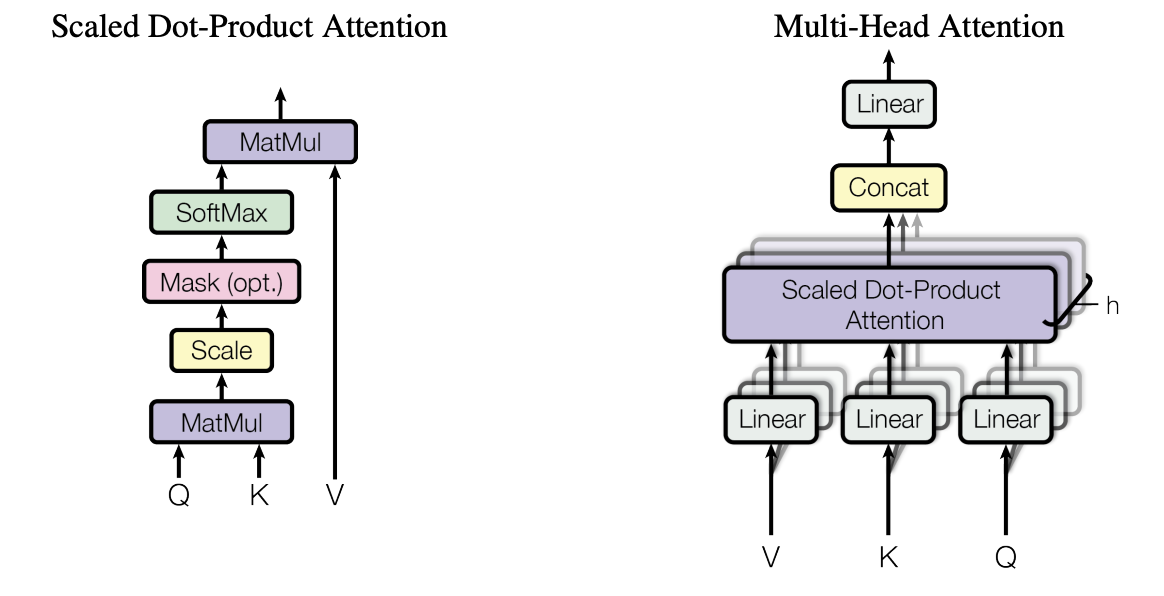


### Attention score
$$
Attention(Q, K, V) = \sigma\left(\frac{QK^\top}{\sqrt{d_k}}V\right)
$$

where: $\sigma(\cdot)$ is the softmax function



### Multi-head attention score
$$
MultiHead(Q, K, V)=Concat(\text{head}_1, ...,\text{head}_h)W^O
$$
where $\text{head}_i = Attention(QW_i^Q, KW_i^K, VW_i^V)$





### Illustration on attention mechanism
![](https://lilianweng.github.io/posts/2018-06-24-attention/xu2015-fig6b.png)
![](https://lilianweng.github.io/posts/2018-06-24-attention/cheng2016-fig1.png)

## Positional encoding

![](https://aiml.com/wp-content/uploads/2023/09/example_of_positional_encoding_in_transformers.png)

## Read more on Attention mechanism
https://classic.d2l.ai/chapter_attention-mechanisms/index.html